In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
data_file = "/FileStore/tables/kddcup_data-0c964.gz"
raw_rdd = sc.textFile(data_file).cache()

In [3]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
sqlContext

Out[ 16 ]: <pyspark.sql.context.SQLContext at 0x7f4325228fd0>

In [4]:
csv_rdd = raw_rdd.map(lambda row: row.split(","))
print(csv_rdd.take(2))
print(type(csv_rdd))

[['0', 'tcp', 'http', 'SF', '215', '45076', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0.00', '0.00', '0.00', '0.00', '1.00', '0.00', '0.00', '0', '0', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', 'normal.'], ['0', 'tcp', 'http', 'SF', '162', '4528', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '2', '2', '0.00', '0.00', '0.00', '0.00', '1.00', '0.00', '0.00', '1', '1', '1.00', '0.00', '1.00', '0.00', '0.00', '0.00', '0.00', '0.00', 'normal.']]
<class 'pyspark.rdd.PipelinedRDD'>

In [5]:
len(csv_rdd.take(1)[0])

Out[ 18 ]: 42

In [6]:
from pyspark.sql import Row

parsed_rdd = csv_rdd.map(lambda r: Row(
    duration=int(r[0]), 
    protocol_type=r[1],
    service=r[2],
    flag=r[3],
    src_bytes=int(r[4]),
    dst_bytes=int(r[5]),
    wrong_fragment=int(r[7]),
    urgent=int(r[8]),
    hot=int(r[9]),
    num_failed_logins=int(r[10]),
    num_compromised=int(r[12]),
    su_attempted=r[14],
    num_root=int(r[15]),
    num_file_creations=int(r[16]),
    label=r[-1]
    )
)
parsed_rdd.take(5)

Out[ 19 ]: 
[Row(dst_bytes=45076, duration=0, flag='SF', hot=0, label='normal.', num_compromised=0, num_failed_logins=0, num_file_creations=0, num_root=0, protocol_type='tcp', service='http', src_bytes=215, su_attempted='0', urgent=0, wrong_fragment=0),
 Row(dst_bytes=4528, duration=0, flag='SF', hot=0, label='normal.', num_compromised=0, num_failed_logins=0, num_file_creations=0, num_root=0, protocol_type='tcp', service='http', src_bytes=162, su_attempted='0', urgent=0, wrong_fragment=0),
 Row(dst_bytes=1228, duration=0, flag='SF', hot=0, label='normal.', num_compromised=0, num_failed_logins=0, num_file_creations=0, num_root=0, protocol_type='tcp', service='http', src_bytes=236, su_attempted='0', urgent=0, wrong_fragment=0),
 Row(dst_bytes=2032, duration=0, flag='SF', hot=0, label='normal.', num_compromised=0, num_failed_logins=0, num_file_creations=0, num_root=0, protocol_type='tcp', service='http', src_bytes=233, su_attempted='0', urgent=0, wrong_fragment=0),
 Row(dst_bytes=486, duration=0, flag='SF', hot=0, label='normal.', num_compromised=0, num_failed_logins=0, num_file_creations=0, num_root=0, protocol_type='tcp', service='http', src_bytes=239, su_attempted='0', urgent=0, wrong_fragment=0)]

In [7]:
df = sqlContext.createDataFrame(parsed_rdd)
display(df.head(10))

dst_bytes,duration,flag,hot,label,num_compromised,num_failed_logins,num_file_creations,num_root,protocol_type,service,src_bytes,su_attempted,urgent,wrong_fragment
45076,0,SF,0,normal.,0,0,0,0,tcp,http,215,0,0,0
4528,0,SF,0,normal.,0,0,0,0,tcp,http,162,0,0,0
1228,0,SF,0,normal.,0,0,0,0,tcp,http,236,0,0,0
2032,0,SF,0,normal.,0,0,0,0,tcp,http,233,0,0,0
486,0,SF,0,normal.,0,0,0,0,tcp,http,239,0,0,0
1282,0,SF,0,normal.,0,0,0,0,tcp,http,238,0,0,0
1337,0,SF,0,normal.,0,0,0,0,tcp,http,235,0,0,0
1364,0,SF,0,normal.,0,0,0,0,tcp,http,234,0,0,0
1295,0,SF,0,normal.,0,0,0,0,tcp,http,239,0,0,0
5450,0,SF,0,normal.,0,0,0,0,tcp,http,181,0,0,0


In [8]:
df.printSchema()

root
-- dst_bytes: long (nullable = true)
-- duration: long (nullable = true)
-- flag: string (nullable = true)
-- hot: long (nullable = true)
-- label: string (nullable = true)
-- num_compromised: long (nullable = true)
-- num_failed_logins: long (nullable = true)
-- num_file_creations: long (nullable = true)
-- num_root: long (nullable = true)
-- protocol_type: string (nullable = true)
-- service: string (nullable = true)
-- src_bytes: long (nullable = true)
-- su_attempted: string (nullable = true)
-- urgent: long (nullable = true)
-- wrong_fragment: long (nullable = true)

In [9]:
df.registerTempTable("connections")

In [10]:
display(df.groupBy('protocol_type')
          .count()
          .orderBy('count', ascending=False))

protocol_type,count
icmp,2833545
tcp,1870598
udp,194288


In [11]:
protocols = sqlContext.sql("""
                           SELECT protocol_type, count(*) as freq
                           FROM connections
                           GROUP BY protocol_type
                           ORDER BY 2 DESC
                           """)
display(protocols)

protocol_type,freq
icmp,2833545
tcp,1870598
udp,194288


In [12]:
labels = sqlContext.sql("""
                           SELECT label, count(*) as freq
                           FROM connections
                           GROUP BY label
                           ORDER BY 2 DESC
                           """)
display(labels)

label,freq
smurf.,2807886
neptune.,1072017
normal.,972781
satan.,15892
ipsweep.,12481
portsweep.,10413
nmap.,2316
back.,2203
warezclient.,1020
teardrop.,979


In [13]:
labels = sqlContext.sql("""
                           SELECT label, count(*) as freq
                           FROM connections
                           GROUP BY label
                           ORDER BY 2 DESC
                           """)
display(labels)

label,freq
smurf.,2807886
neptune.,1072017
normal.,972781
satan.,15892
ipsweep.,12481
portsweep.,10413
nmap.,2316
back.,2203
warezclient.,1020
teardrop.,979


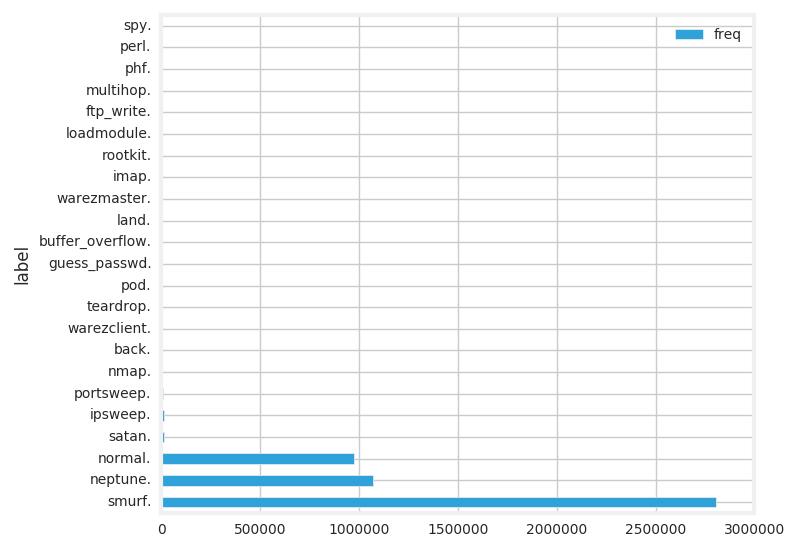

In [14]:
labels_df = pd.DataFrame(labels.toPandas())
labels_df.set_index("label", drop=True,inplace=True)
labels_fig = labels_df.plot(kind='barh')

plt.rcParams["figure.figsize"] = (7, 5)
plt.rcParams.update({'font.size': 10})
plt.tight_layout()
display(labels_fig.figure)

In [15]:
attack_protocol = sqlContext.sql("""
                           SELECT 
                             protocol_type, 
                             CASE label
                               WHEN 'normal.' THEN 'no attack'
                               ELSE 'attack'
                             END AS state,
                             COUNT(*) as freq
                           FROM connections
                           GROUP BY protocol_type, state
                           ORDER BY 3 DESC
                           """)
display(attack_protocol)

protocol_type,state,freq
icmp,attack,2820782
tcp,attack,1101928
tcp,no attack,768670
udp,no attack,191348
icmp,no attack,12763
udp,attack,2940


In [16]:
attack_stats = sqlContext.sql("""
                           SELECT 
                             protocol_type, 
                             CASE label
                               WHEN 'normal.' THEN 'no attack'
                               ELSE 'attack'
                             END AS state,
                             COUNT(*) as total_freq,
                             ROUND(AVG(src_bytes), 2) as mean_src_bytes,
                             ROUND(AVG(dst_bytes), 2) as mean_dst_bytes,
                             ROUND(AVG(duration), 2) as mean_duration,
                             SUM(num_failed_logins) as total_failed_logins,
                             SUM(num_compromised) as total_compromised,
                             SUM(num_file_creations) as total_file_creations,
                             SUM(su_attempted) as total_root_attempts,
                             SUM(num_root) as total_root_acceses
                           FROM connections
                           GROUP BY protocol_type, state
                           ORDER BY 3 DESC
                           """)
display(attack_stats)

protocol_type,state,total_freq,mean_src_bytes,mean_dst_bytes,mean_duration,total_failed_logins,total_compromised,total_file_creations,total_root_attempts,total_root_acceses
icmp,attack,2820782,931.68,0.0,0.0,0,0,0,0.0,0
tcp,attack,1101928,4465.81,2005.96,22.6,61,2276,96,1.0,159
tcp,no attack,768670,1844.29,4071.32,11.48,96,37344,5727,179.0,63202
udp,no attack,191348,98.32,89.41,1061.26,0,0,0,0.0,0
icmp,no attack,12763,90.68,0.0,0.0,0,0,0,0.0,0
udp,attack,2940,26.4,0.82,0.0,0,0,0,0.0,0


In [17]:
tcp_attack_stats = sqlContext.sql("""
                                   SELECT 
                                     service,
                                     label as attack_type,
                                     COUNT(*) as total_freq,
                                     ROUND(AVG(duration), 2) as mean_duration,
                                     SUM(num_failed_logins) as total_failed_logins,
                                     SUM(num_file_creations) as total_file_creations,
                                     SUM(su_attempted) as total_root_attempts,
                                     SUM(num_root) as total_root_acceses
                                   FROM connections
                                   WHERE protocol_type = 'tcp'
                                   AND label != 'normal.'
                                   GROUP BY service, attack_type
                                   ORDER BY total_freq DESC
                                   """)
display(tcp_attack_stats)

service,attack_type,total_freq,mean_duration,total_failed_logins,total_file_creations,total_root_attempts,total_root_acceses
private,neptune.,1013720,0.0,0,0,0.0,0
other,satan.,12192,0.0,0,0,0.0,0
private,portsweep.,7200,2457.61,0,0,0.0,0
other,portsweep.,2649,1663.99,0,0,0.0,0
http,back.,2203,0.13,0,0,0.0,0
telnet,neptune.,1923,0.0,0,0,0.0,0
ftp_data,neptune.,1805,0.0,0,0,0.0,0
http,neptune.,1801,0.0,0,0,0.0,0
finger,neptune.,1800,0.0,0,0,0.0,0
private,satan.,1708,0.1,0,0,0.0,0


In [18]:
tcp_attack_stats = sqlContext.sql("""
                                   SELECT 
                                     service,
                                     label as attack_type,
                                     COUNT(*) as total_freq,
                                     ROUND(AVG(duration), 2) as mean_duration,
                                     SUM(num_failed_logins) as total_failed_logins,
                                     SUM(num_file_creations) as total_file_creations,
                                     SUM(su_attempted) as total_root_attempts,
                                     SUM(num_root) as total_root_acceses
                                   FROM connections
                                   WHERE (protocol_type = 'tcp'
                                          AND label != 'normal.')
                                   GROUP BY service, attack_type
                                   HAVING (mean_duration >= 50
                                           AND total_file_creations >= 5
                                           AND total_root_acceses >= 1)
                                   ORDER BY total_freq DESC
                                   """)
display(tcp_attack_stats)

service,attack_type,total_freq,mean_duration,total_failed_logins,total_file_creations,total_root_attempts,total_root_acceses
telnet,buffer_overflow.,21,130.67,0,15,0.0,5
telnet,ipsweep.,14,912.64,0,18,0.0,4
telnet,loadmodule.,5,63.8,0,9,0.0,3
telnet,multihop.,2,458.0,0,8,0.0,93


In [19]:
tcp_attack_stats = sqlContext.sql("""
                                   SELECT 
                                     t.service,
                                     t.attack_type,
                                     t.total_freq
                                   FROM
                                   (SELECT 
                                     service,
                                     label as attack_type,
                                     COUNT(*) as total_freq,
                                     ROUND(AVG(duration), 2) as mean_duration,
                                     SUM(num_failed_logins) as total_failed_logins,
                                     SUM(num_file_creations) as total_file_creations,
                                     SUM(su_attempted) as total_root_attempts,
                                     SUM(num_root) as total_root_acceses
                                   FROM connections
                                   WHERE protocol_type = 'tcp'
                                   AND label != 'normal.'
                                   GROUP BY service, attack_type
                                   ORDER BY total_freq DESC) as t
                                     WHERE t.mean_duration > 0 
                                   """)
display(tcp_attack_stats)

service,attack_type,total_freq
private,portsweep.,7200
other,portsweep.,2649
http,back.,2203
private,satan.,1708
ftp_data,warezclient.,708
ftp,warezclient.,307
telnet,guess_passwd.,53
finger,satan.,27
telnet,buffer_overflow.,21
ftp_data,warezmaster.,18


In [20]:
display((tcp_attack_stats.groupby('service')
                         .pivot('attack_type')
                         .agg({'total_freq':'max'})
                         .na.fill(0))
)

service,back.,buffer_overflow.,ftp_write.,guess_passwd.,imap.,ipsweep.,loadmodule.,multihop.,perl.,phf.,portsweep.,rootkit.,satan.,spy.,warezclient.,warezmaster.
telnet,0,21,0,53,0,14,5,2,3,0,13,5,7,2,0,0
ftp,0,1,2,0,0,13,1,2,0,0,13,1,8,0,307,2
auth,0,0,0,0,0,0,0,0,0,0,9,0,7,0,0,0
iso_tsap,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0
systat,0,0,0,0,0,0,0,0,0,0,14,0,0,0,0,0
name,0,0,0,0,0,0,0,0,0,0,14,0,0,0,0,0
sql_net,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0
pop_3,0,0,0,0,0,0,0,0,0,0,9,0,3,0,0,0
discard,0,0,0,0,0,0,0,0,0,0,15,0,3,0,0,0
Z39_50,0,0,0,0,0,0,0,0,0,0,9,0,0,0,0,0
